In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
sns.set_style('darkgrid')

In [3]:
chunk_size = 10000

In [4]:
# Load v1 & v2 train data

df_train_v1 = pd.read_csv('train.csv')
df_train_v2 = pd.read_csv('train_v2.csv')
df_train = pd.concat([df_train_v1, df_train_v2], ignore_index=True).reset_index(drop=True)
df_train.drop_duplicates('msno',keep='last',inplace=True)

In [5]:
# load test data

df_test = pd.read_csv('sample_submission_v2.csv')

In [6]:
# Load members with msno only in the train data

df_members = pd.read_csv('members_v3.csv')

In [7]:
chunks_trans = pd.read_csv('transactions.csv', iterator=True, chunksize=chunk_size)

df_trans = pd.concat(list(chunks_trans), ignore_index=True)

In [8]:
df_trans = pd.concat([df_trans, pd.read_csv('transactions_v2.csv')], ignore_index=True)

In [9]:
#f,ax=plt.subplots(1,2,figsize=(16,8))
#sns.stripplot(x="is_churn", y="city", data=df_members_train, ax=ax[0])
#sns.countplot(x='city', data=df_members_train, ax=ax[1])

In [10]:
#f,ax=plt.subplots(1,2,figsize=(16,8))
#sns.stripplot(x="is_churn", y="registered_via", data=df_members_train, ax=ax[0])
#sns.countplot(x='registered_via', data=df_members_train, ax=ax[1])

# Features engineering for members.csv

In [11]:
#df_members['registration_init_dtime'] = pd.to_datetime(df_members['registration_init_time'],format='%Y%m%d')

In [12]:
#from datetime import date

#df_members['subscription_days'] = (date(2017,4,30) - df_members['registration_init_time']).dt.days

In [14]:
# drop useless columns before merging with df_trans

df_members.drop(['gender','bd'],axis=1,inplace=True)

In [15]:
#sns.countplot(x='is_churn',data=df_members_train)

In [16]:
#f,ax=plt.subplots(1,2,figsize=(16,8))
#sns.distplot(df_members_train['subscription_days'], bins=20, ax=ax[0])
#sns.countplot(x='subscription_days',data=df_members_train,hue='is_churn', palette='YlGnBu')

In [17]:
#sns.pairplot(df_members_train[['city','registered_via','is_churn','subscription_days']], hue='is_churn')

In [18]:
df_members_train = pd.merge(df_members, df_train, on='msno', how='right')
df_members_test = pd.merge(df_members, df_test, on='msno', how='right')

In [19]:
df_members_test.shape

(907471, 5)

# Features engineering for transactions.csv

In [20]:
# merge df_trans and df_members_trains so only has to process msnos that are in train.csv

df_merge = pd.merge(df_trans, pd.concat([df_members_train,df_members_test],ignore_index=True), on='msno', how='right')

In [21]:
# drop rows that have no payments

#df_merge = df_merge.drop(df_merge[df_merge['actual_amount_paid'] <= 0].index)

In [22]:
# Format dates columns into datetime

df_merge['transaction_dtime'] = pd.to_datetime(df_merge['transaction_date'],format='%Y%m%d')
df_merge['membership_expire_dtime'] = pd.to_datetime(df_merge['membership_expire_date'],format='%Y%m%d')

In [23]:
# Re-calculate payment_plan_days if 0

#df_merge['payment_plan_days'] = np.where(df_merge['payment_plan_days']==0,(df_merge['membership_expire_dtime']-df_merge['transaction_dtime']).dt.days,df_merge['payment_plan_days'])

df_merge.loc[df_merge['payment_plan_days']==0,'payment_plan_days'] = (df_merge['membership_expire_dtime']-df_merge['transaction_dtime']).dt.days

In [25]:
#Set payment_plan_days back to 0 if re-calculation is -ive

df_merge.loc[df_merge['payment_plan_days']<0,'payment_plan_days'] = 0

In [26]:
#a If plan_list_price is 0 assume it is actual_amount_paid

df_merge.loc[df_merge['plan_list_price']<=0,'plan_list_price'] = df_merge['actual_amount_paid']

In [27]:
groupby_msno = df_merge.groupby(df_merge['msno'])

In [28]:
# Count # of transactions

df_merge['trans_count'] = groupby_msno['payment_method_id'].transform('count')

In [29]:
# Total subscription days

df_merge['total_pay_days'] = groupby_msno['payment_plan_days'].transform('sum')

In [30]:
# Average payment in each transaction

df_merge['avg_pay'] = groupby_msno['actual_amount_paid'].transform('mean')

In [31]:
# Total subscription payment

df_merge['total_payments'] = groupby_msno['actual_amount_paid'].transform('sum')

In [32]:
# Assume is_cancel = 1 with actual payment > 0 is a plan change; count the total number of plan changes

#df_merge['count_plan_change'] = groupby_msno['is_cancel'].transform(lambda x: (x==1).sum())

In [33]:
# Count # of auto_renew

#df_merge['count_auto_renew'] = groupby_msno['is_auto_renew'].transform(lambda x: (x==1).sum())

In [46]:
# Average list Price

df_merge['avg_list_price'] = groupby_msno['plan_list_price'].transform('mean')

In [36]:
# Keep only the record with the most recent transaction date 

df_merge = df_merge.sort_values(by=['transaction_date'], ascending=False).reset_index(drop=True)
df_merge.drop_duplicates('msno',keep='first',inplace=True)

In [ ]:
# Calculate last transaction is how many days ago from April

#df_merge['last_trans_days_ago'] = (date(2017,4,30) - df_merge['transaction_date']).dt.days

In [ ]:
#df_merge['membership_expiry_days'] = (date(2017,4,30) - df_merge['membership_expire_date']).dt.days

In [47]:
df_merge_train = pd.merge(df_merge.drop('is_churn',axis=1), df_train, on='msno', how='right')
df_merge_test = pd.merge(df_merge.drop('is_churn',axis=1), df_test, on='msno', how='right')

In [48]:
df_merge_test.drop('is_churn',inplace=True,axis=1)

# Training the models

In [44]:
from sklearn.model_selection import train_test_split

In [49]:
features = ['city', 
            'registered_via', 
            'trans_count', 
            'total_pay_days', 
            'avg_pay', 
            'total_payments', 
            'is_cancel', 
            'is_auto_renew', 
            'avg_list_price',
            'registration_init_time',
            'transaction_date',
            'membership_expire_date',
            'payment_method_id',
            'payment_plan_days',
            'actual_amount_paid',
            'plan_list_price']

X = df_merge_train[features]
y = df_merge_train['is_churn']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

# XGBoost with RandomizeSearchCV

In [51]:
from xgboost import XGBClassifier

/Users/whyi/Applications/anaconda/envs/MachineLearning/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [52]:
xgb = XGBClassifier(max_depth=7,learning_rate=0.02,n_estimators=300,silent=False,objective='binary:logistic', seed=50)

In [66]:
eval_set = [(X_test, y_test)]

xgb.fit(X_train, y_train, eval_set=eval_set, eval_metric='logloss', early_stopping_rounds=30)

[0]	validation_0-logloss:0.675237
Will train until validation_0-logloss hasn't improved in 30 rounds.
[1]	validation_0-logloss:0.658029
[2]	validation_0-logloss:0.641483
[3]	validation_0-logloss:0.625563
[4]	validation_0-logloss:0.610236
[5]	validation_0-logloss:0.595468
[6]	validation_0-logloss:0.581234
[7]	validation_0-logloss:0.567501
[8]	validation_0-logloss:0.554249
[9]	validation_0-logloss:0.541452
[10]	validation_0-logloss:0.529091
[11]	validation_0-logloss:0.517144
[12]	validation_0-logloss:0.505586
[13]	validation_0-logloss:0.494416
[14]	validation_0-logloss:0.483597
[15]	validation_0-logloss:0.473128
[16]	validation_0-logloss:0.462993
[17]	validation_0-logloss:0.453178
[18]	validation_0-logloss:0.443666
[19]	validation_0-logloss:0.434443
[20]	validation_0-logloss:0.425494
[21]	validation_0-logloss:0.416822
[22]	validation_0-logloss:0.408403
[23]	validation_0-logloss:0.400238
[24]	validation_0-logloss:0.392307
[25]	validation_0-logloss:0.384609
[26]	validation_0-logloss:0.3771

[230]	validation_0-logloss:0.0832
[231]	validation_0-logloss:0.083124
[232]	validation_0-logloss:0.083049
[233]	validation_0-logloss:0.082976
[234]	validation_0-logloss:0.082905
[235]	validation_0-logloss:0.082837
[236]	validation_0-logloss:0.082769
[237]	validation_0-logloss:0.082704
[238]	validation_0-logloss:0.082639
[239]	validation_0-logloss:0.082581
[240]	validation_0-logloss:0.082523
[241]	validation_0-logloss:0.082461
[242]	validation_0-logloss:0.082405
[243]	validation_0-logloss:0.08235
[244]	validation_0-logloss:0.082139
[245]	validation_0-logloss:0.082085
[246]	validation_0-logloss:0.082029
[247]	validation_0-logloss:0.081837
[248]	validation_0-logloss:0.081786
[249]	validation_0-logloss:0.081736
[250]	validation_0-logloss:0.08156
[251]	validation_0-logloss:0.081512
[252]	validation_0-logloss:0.081465
[253]	validation_0-logloss:0.081284
[254]	validation_0-logloss:0.08124
[255]	validation_0-logloss:0.081196
[256]	validation_0-logloss:0.081148
[257]	validation_0-logloss:0.0809

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=50, silent=False, subsample=1)

# Prediction and Evaluations

In [99]:
predictions = xgb.predict_proba(X_test)

In [88]:
from sklearn.metrics import classification_report,confusion_matrix,log_loss

In [89]:
print(confusion_matrix(y_test,predictions))

[[281355   3143]
 [  5674  34485]]


In [90]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.98      0.99      0.98    284498
          1       0.92      0.86      0.89     40159

avg / total       0.97      0.97      0.97    324657



In [100]:
print(log_loss(y_test,predictions))

0.0796651923464


In [101]:
predictions

array([[ 0.86457932,  0.13542067],
       [ 0.99721152,  0.00278846],
       [ 0.99742669,  0.00257329],
       ..., 
       [ 0.02027071,  0.97972929],
       [ 0.99792111,  0.00207887],
       [ 0.99791968,  0.00208029]], dtype=float32)

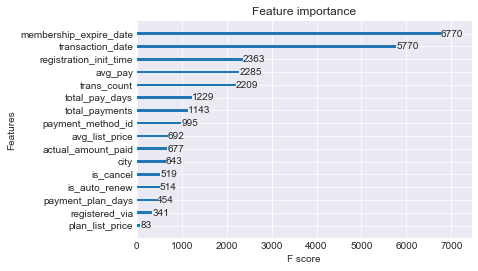

In [72]:
from xgboost import plot_importance

plot_importance(xgb)

# Tuning XGBoost

max_depth=10
min_child_weight=5

In [74]:
import xgboost as xgbt

In [76]:
d_train = xgbt.DMatrix(X_train, label=y_train)
d_test = xgbt.DMatrix(X_test, label=y_test)

In [77]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'binary:logistic',
    'eval_metric': "logloss"
}

In [78]:
model = xgbt.train(
    params,
    d_train,
    num_boost_round=999,
    evals=[(d_test, 'is_churn')],
    early_stopping_rounds=10
)

[0]	is_churn-logloss:0.463522
Will train until is_churn-logloss hasn't improved in 10 rounds.
[1]	is_churn-logloss:0.337259
[2]	is_churn-logloss:0.25878
[3]	is_churn-logloss:0.205563
[4]	is_churn-logloss:0.169425
[5]	is_churn-logloss:0.144182
[6]	is_churn-logloss:0.12645
[7]	is_churn-logloss:0.113955
[8]	is_churn-logloss:0.10491
[9]	is_churn-logloss:0.098245
[10]	is_churn-logloss:0.092863
[11]	is_churn-logloss:0.089441
[12]	is_churn-logloss:0.08706
[13]	is_churn-logloss:0.084983
[14]	is_churn-logloss:0.08365
[15]	is_churn-logloss:0.082696
[16]	is_churn-logloss:0.082017
[17]	is_churn-logloss:0.080526
[18]	is_churn-logloss:0.079999
[19]	is_churn-logloss:0.079676
[20]	is_churn-logloss:0.07943
[21]	is_churn-logloss:0.079036
[22]	is_churn-logloss:0.078712
[23]	is_churn-logloss:0.07853
[24]	is_churn-logloss:0.078317
[25]	is_churn-logloss:0.078225
[26]	is_churn-logloss:0.078165
[27]	is_churn-logloss:0.078109
[28]	is_churn-logloss:0.078088
[29]	is_churn-logloss:0.078084
[30]	is_churn-logloss:0

In [79]:
 model.best_iteration

44

In [81]:
cv_results = xgbt.cv(
    params,
    d_train,
    num_boost_round=999,
    seed=42,
    nfold=5,
    metrics={'logloss'},
    early_stopping_rounds=10
)

cv_results

,test-logloss-mean,test-logloss-std,train-logloss-mean,train-logloss-std
0,0.463628,0.000196,0.463565,0.000079
1,0.337609,0.000360,0.337500,0.000094
2,0.259260,0.000468,0.259105,0.000156
3,0.206125,0.000535,0.205936,0.000156
4,0.170133,0.000600,0.169902,0.000195
5,0.144985,0.000685,0.144721,0.000145
6,0.127480,0.000629,0.127167,0.000249
7,0.115158,0.000663,0.114804,0.000319
8,0.105840,0.000713,0.105445,0.000340
9,0.099230,0.000711,0.098778,0.000403


In [82]:
cv_results['test-logloss-mean'].min()

0.079019599999999995

In [83]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [85]:
# Define initial best params and Logloss
min_logloss = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgbt.cv(
        params,
        d_train,
        num_boost_round=999,
        seed=42,
        nfold=5,
        metrics={'logloss'},
        early_stopping_rounds=10
    )

    # Update best logloss
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogloss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, Logloss: {}".format(best_params[0], best_params[1], min_logloss))

CV with max_depth=9, min_child_weight=5
	Logloss 0.0764872 for 39 rounds
CV with max_depth=9, min_child_weight=6
	Logloss 0.0770062 for 63 rounds
CV with max_depth=9, min_child_weight=7
	Logloss 0.0763042 for 74 rounds
CV with max_depth=10, min_child_weight=5
	Logloss 0.0756488 for 34 rounds
CV with max_depth=10, min_child_weight=6
	Logloss 0.0766092 for 59 rounds
CV with max_depth=10, min_child_weight=7
	Logloss 0.07595099999999999 for 38 rounds
CV with max_depth=11, min_child_weight=5
	Logloss 0.0764628 for 64 rounds
CV with max_depth=11, min_child_weight=6
	Logloss 0.0760922 for 53 rounds
CV with max_depth=11, min_child_weight=7
	Logloss 0.0756738 for 53 rounds


NameError: name 'min_mae' is not defined

In [86]:
print("Best params: {}, {}, Logloss: {}".format(best_params[0], best_params[1], min_logloss))

Best params: 10, 5, Logloss: 0.0756488


# Prediction test file

In [113]:
df_merge_test['is_churn'] = xgb.predict_proba(df_merge_test[features])[:,1]

In [115]:
df_merge_test[['msno','is_churn']].to_csv('submission.csv.gz', index=False, compression='gzip')